# Car Image Embedding and Subsampling

In [41]:
%matplotlib inline

In [86]:
data_dir = 'data'
collection = 'pascal-voc-2012'
annotation_file = 'ImageSets/Main/car_trainval.txt'
width = 320
height = 240

In [134]:
target_size = width * height
target_aspect_ratio = width / height
img_dir = f'{data_dir}/{collection}/JPEGImages'
cars_dir = f'{data_dir}/{collection}-cars'

In [131]:
from imageio import imread

positives = {}
positives_gray = {}

with open(f'{data_dir}/{collection}/{annotation_file}', 'r') as f:
    lines = f.readlines()

    for line in lines: 
        filename, label = line.strip().split()
        
        if label == '1':
            positives[filename] = imread(f'{img_dir}/{filename}.jpg')
            positives_gray[filename] = imread(f'{img_dir}/{filename}.jpg', as_gray=True)

print(f'Found {len(positives)} car images')

Found 1161 car images


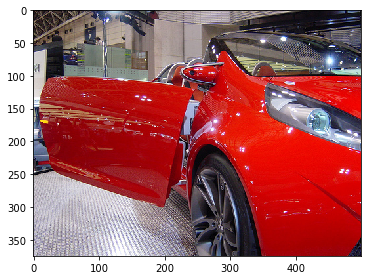

In [132]:
from skimage.io import imshow
imshow(positives['2008_000027'])

## Resize and save images

In [147]:
from pathlib import Path
from PIL import Image
from skimage.transform import resize

Path(cars_dir).mkdir(parents=True, exist_ok=True)

min_size = width * height

final_imgs = []
scaled_imgs = []

for filename in positives:
    img = positives[filename]
    img_gray = positives_gray[filename]
    h, w = img_gray.shape
    size = w * h
    aspect_ratio = w / h
    if w >= width and h >= height:
        if aspect_ratio > 1:
            # Landscape
            if aspect_ratio > target_aspect_ratio:
                # Wider than the target so we scale by height
                scale_factor = height / h
                nh = height
                nw = round(w * scale_factor)
                
            else:
                # Taller than the target so we scale by width
                scale_factor = width / w
                nh = round(h * scale_factor)
                nw = width
            
            scaled_img = resize(img, (nh, nw), anti_aliasing=False)
            scaled_img_gray = resize(img_gray, (nh, nw), anti_aliasing=False)
            
            xOffset = math.floor((nw - width) / 2)
            yOffset = math.floor((nh - height) / 2)
            
            scaled_img = scaled_img[yOffset:yOffset+height, xOffset:xOffset+width]
            scaled_img_gray = scaled_img_gray[yOffset:yOffset+height, xOffset:xOffset+width]
            
        else:
            adjusted_aspect_ratio = 1 / target_aspect_ratio

            # Portrait
            if aspect_ratio > adjusted_aspect_ratio:
                # Wider than the target so we scale by height
                scale_factor = height / w
                nh = width
                nw = round(w * scale_factor)
                
            else:
                # Taller than the target so we scale by width
                scale_factor = width / h
                nh = round(h * scale_factor)
                nw = height
            
            scaled_img = resize(img, (nh, nw), anti_aliasing=False)
            scaled_img_gray = resize(img_gray, (nh, nw), anti_aliasing=False)
            
            xOffset = math.floor((nw - height) / 2)
            yOffset = math.floor((nh - width) / 2)
            
            scaled_img = scaled_img[yOffset:yOffset+width, xOffset:xOffset+height]
            scaled_img_gray = scaled_img_gray[yOffset:yOffset+width, xOffset:xOffset+height]
            
        rh, rw = scaled_img_gray.shape
        
        if rh * rw == target_size:
            final_imgs.append(filename)
            scaled_imgs.append(scaled_img_gray.flatten())
            scaled_img *= 255
            Image.fromarray(scaled_img.astype(np.uint8)).save(f'{cars_dir}/{filename}.jpg', quality=70)
        else:
            print(f'{filename} with {rw}x{rh} == {rh*rw}')

scaled_imgs = np.vstack(scaled_imgs)

n, dim = scaled_imgs.shape

print(f'Final number of cropped and resized images is {n}')

Final number of cropped and resized images is 1142


## Test SSIM

In [122]:
from skimage.metrics import structural_similarity as ssim
from itertools import combinations
import numpy as np
import time

norm_scaled_imgs = scaled_imgs / 255.0

num_combinations = (n * (n - 1)) / 2
print(f'{num_combinations} pairwise distances need to be computed')

s = time.time()
k = 100
t = 0
for i, c in enumerate(combinations(np.arange(n), 2)):
    if i % k == k - 1:
        t = time.time() - s
        print(f'{k} computations took {t:.2f} sec')
        break
    ssim(norm_scaled_imgs[c[0]], norm_scaled_imgs[c[1]], data_range=1.0)

total_time = num_combinations / k * t / 60

print(f'Total time will take about {total_time:.1f} mins')

651511.0 pairwise distances need to be computed
100 computations took 0.31 sec
Total time will take about 34.1 mins


In [123]:
dist_ssim = np.zeros((n, n))

l = 0
for k, c in enumerate(combinations(np.arange(n), 2)):
    if k % 10000 == 9999:
        l += 1
        print(f'{l},', end='', flush=True)
        
    i, j = c
    d = ssim(norm_scaled_imgs[i], norm_scaled_imgs[j], data_range=1.0)
    dist_ssim[i,j] = d
    dist_ssim[j,i] = d

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,

## Compute Embedding

In [125]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [127]:
umap_ssim = UMAP(n_neighbors=5, metric='precomputed').fit_transform(np.abs(dist_ssim))

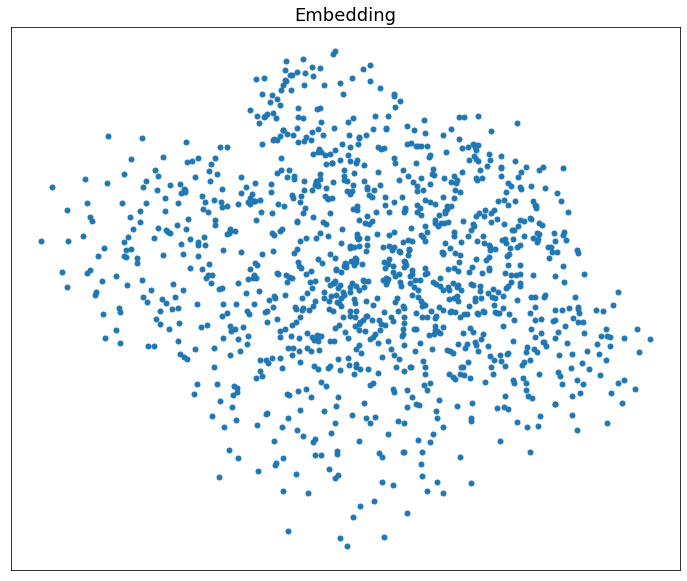

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(umap_ssim[:, 0], umap_ssim[:, 1], s=25)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Embedding", fontsize=18)
plt.show()

In [129]:
scaler = MinMaxScaler((0.05, 0.95))
umap_ssim_scaled = scaler.fit_transform(umap_ssim)

## Save Data

In [149]:
out_img_dir = 'data/pascal-voc-2012-cars'

data = []

for i in range(umap_ssim_scaled.shape[0]):
    item = {}
    item['src'] = f'{out_img_dir}/{final_imgs[i]}.jpg'
    item['embedding'] = umap_ssim_scaled[i].tolist()
    data.append(item)

In [150]:
import json

with open('data/pascal-voc-cars.json', 'w') as f:
    json.dump(data, f)